### Train Model with LSTM

In [1]:
import pandas as pd
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers import Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np
from preprocessing import PrepareData
# from jupyterthemes import jtplot
# jtplot.style()
from keras.layers import TimeDistributed
from keras.callbacks import ReduceLROnPlateau
import datetime
from keras.callbacks import TensorBoard
import random

Using TensorFlow backend.


In [2]:
def shuffle(X,Y):
    np.random.seed(10)
    randomList = np.arange(X.shape[0])
    np.random.shuffle(randomList)
    return X[randomList], Y[randomList]

In [3]:
def splitData(X,Y,rate):
    X_train = X[int(X.shape[0]*rate):]
    Y_train = Y[int(Y.shape[0]*rate):]
    X_val = X[:int(X.shape[0]*rate)]
    Y_val = Y[:int(Y.shape[0]*rate)]
    return X_train, Y_train, X_val, Y_val

In [173]:
def buildTrain(train, timesteps=5):
    print "train shape:", train.shape
    X_train, Y_train = [], []
    sales = train['SalePrice']
    train.drop("SalePrice", axis=1, inplace=True)
    for i in range(train.shape[0]-timesteps+1):
        X_train.append(np.array(train.iloc[i:i+timesteps]))
        Y_train.append(np.array(sales.iloc[i+timesteps-1: i+timesteps]))
    print "X_train shape:", np.array(X_train).shape
    return np.array(X_train), np.array(Y_train)

In [181]:
def buildTest(test, timesteps=5):
    X_test = []
    for i in range(test.shape[0]-timesteps+1):
        X_test.append(np.array(test.iloc[i:i+timesteps]))
    return np.array(X_test)

In [95]:
def buildModel(shape):
    model = Sequential()
    model.add(LSTM(5, input_shape=(shape[1], shape[2]), return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(200))
    model.add(Dropout(0.5))
    model.add(Dense(200))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation="tanh"))
    model.compile(loss="mean_squared_error", optimizer="adam")
    model.summary()
    return model

In [96]:
def train_model(X_train, Y_train, X_val=None, Y_val=None):
    batch_size = 5
    model = buildModel(X_train.shape)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)
    early_stop = EarlyStopping(monitor="val_loss", patience=20, verbose=1, mode="auto")
    tf_board = TensorBoard(log_dir='./logs/{}'.format(datetime.datetime.now().strftime('%H_%M')), histogram_freq=0, batch_size=batch_size, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None)
    if X_val is None or Y_val is None:
        kwargs = {}
    else:
        kwargs = {
            "validation_data": (X_val, Y_val)
        }
    history = model.fit(X_train, Y_train, epochs=200, shuffle=True, batch_size=batch_size, callbacks=[tf_board, reduce_lr, early_stop], **kwargs)
    return model, history


In [97]:
def convert_to_price(sales, predict_results):
    max_s = sales.SalePrice.max()
    min_s = sales.SalePrice.min()
    predicted_p = predict_results*(max_s - min_s) + min_s
    return predicted_p

In [174]:
timesteps = 5
ppd = PrepareData()
df, sale_price = ppd.get_train_data(time_series=True)
X_train_all, Y_train_all = buildTrain(df, timesteps=timesteps)
X_train, Y_train = shuffle(X_train_all, Y_train_all)
X_train, Y_train, X_val, Y_val = splitData(X_train, Y_train, 0.1)

train shape: (1460, 246)
X_train shape: (1456, 5, 245)


In [154]:
for item in [df, X_train_all, X_train, Y_train, X_val, Y_val]:
    print item.shape

(1460, 245)
(1456, 5, 245)
(1311, 5, 245)
(1311, 1)
(145, 5, 245)
(145, 1)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 5)                 5020      
_________________________________________________________________
dropout_14 (Dropout)         (None, 5)                 0         
_________________________________________________________________
dense_14 (Dense)             (None, 200)               1200      
_________________________________________________________________
dropout_15 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_16 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 201       
Total para

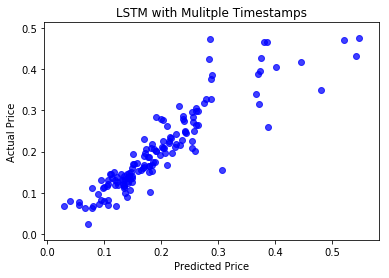

In [155]:
model, history = train_model(X_train, Y_train, X_val, Y_val)
# make a prediction
pred_train = model.predict(X_train)
print 'RMSE (Training Data):', mean_squared_error(Y_train , pred_train)
pred_test = model.predict(X_val)
print 'RMSE (Testin Data):', mean_squared_error(Y_val , pred_test)

# show distribution
plt.scatter(pred_test, Y_val, alpha=.75,
            color='b') #alpha helps to show overlapping data
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('LSTM with Mulitple Timestamps')
plt.show()

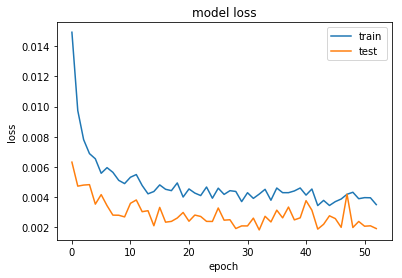

In [156]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [157]:
df_padding = df.sort_index().head(timesteps-1)
test_df, test_ids = ppd.get_test_data(time_series=True)

print df_padding.shape
print test_df.shape

(4, 245)
(1459, 245)


In [182]:
test_df_padded = pd.concat([df_padding, test_df], ignore_index=True)

In [189]:
X = buildTest(test_df_padded, timesteps=5)
print "Make sure the shift is correct by checking:", X[0][timesteps-1][0]

In [192]:
model2, history2 = train_model(X_train_all, Y_train_all)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 5)                 5020      
_________________________________________________________________
dropout_20 (Dropout)         (None, 5)                 0         
_________________________________________________________________
dense_20 (Dense)             (None, 200)               1200      
_________________________________________________________________
dropout_21 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_22 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 201       
Total para

1456/1456 [==============================] - 1s 1ms/step - loss: 0.0037
Epoch 83/200
1456/1456 [==============================] - 1s 1ms/step - loss: 0.0035
Epoch 84/200
1456/1456 [==============================] - 2s 1ms/step - loss: 0.0032
Epoch 85/200
1456/1456 [==============================] - 1s 1ms/step - loss: 0.0031
Epoch 86/200
1456/1456 [==============================] - 1s 1ms/step - loss: 0.0035
Epoch 87/200
1456/1456 [==============================] - 1s 1ms/step - loss: 0.0028
Epoch 88/200
1456/1456 [==============================] - 1s 1ms/step - loss: 0.0036
Epoch 89/200
1456/1456 [==============================] - 1s 1ms/step - loss: 0.0030
Epoch 90/200
1456/1456 [==============================] - 1s 1ms/step - loss: 0.0032
Epoch 91/200
1456/1456 [==============================] - 1s 1ms/step - loss: 0.0039
Epoch 92/200
1456/1456 [==============================] - 1s 1ms/step - loss: 0.0030
Epoch 93/200
1456/1456 [==============================] - 1s 1ms/step - loss: 

1456/1456 [==============================] - 2s 1ms/step - loss: 0.0034
Epoch 178/200
1456/1456 [==============================] - 2s 1ms/step - loss: 0.0034
Epoch 179/200
1456/1456 [==============================] - 2s 1ms/step - loss: 0.0037
Epoch 180/200
1456/1456 [==============================] - 2s 1ms/step - loss: 0.0032
Epoch 181/200
1456/1456 [==============================] - 2s 1ms/step - loss: 0.0033
Epoch 182/200
1456/1456 [==============================] - 2s 1ms/step - loss: 0.0033
Epoch 183/200
1456/1456 [==============================] - 2s 1ms/step - loss: 0.0028
Epoch 184/200
1456/1456 [==============================] - 2s 1ms/step - loss: 0.0030
Epoch 185/200
1456/1456 [==============================] - 2s 1ms/step - loss: 0.0030
Epoch 186/200
1456/1456 [==============================] - 2s 1ms/step - loss: 0.0036
Epoch 187/200
1456/1456 [==============================] - 2s 1ms/step - loss: 0.0035
Epoch 188/200
1456/1456 [==============================] - 2s 1ms/st

In [198]:
results = model2.predict(X)

In [199]:
price = convert_to_price(sale_price, results)

In [200]:
test_ids['SalePrice'] = price

In [201]:
test_results = test_ids.sort_values('Id')

In [202]:
test_results.to_csv("submission_{}.csv".format(datetime.datetime.now().strftime("%H_%M")), index=False)